In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="custom.css">

In [22]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    'width': 1300,
    'height': 400,
})

{'width': 1300, 'height': 400}

# Projects Status Report
### Deep Learning for Healthcare Imaging


**Application support group meeting**, Garching bei M&uuml;nchen, Mon 30.09.2019

*Giuseppe Di Bernardo*[<sup>1</sup>](#fn1)   

<span id="fn1">Data Analytics member @MPCDF</span>  
<img src="./img/brain.jpg" width="35%" align="center">
Slides: <a href="https://giuseppe82.github.io/projects-report/#/">https://giuseppe82.github.io/projects-report/#/</a>
<!--
Notebook: <a href="https://github.com/fmaussion/teaching/blob/master/xarray_intro_acinn/ACINN_workshop_xarray-slides.ipynb"> On GitHub</a> 
-->

## Agenda

<span style="display:block; height: 10;"></span>

<section>
<ol>
<li class="fragment fade-right">First Study Case: Automatic Segmentation of 3D Medical Images
    <ul>
       <span style="display:block; height: 5;"></span>
       <li class="fragment">Scalable high performance for Deep Learning <b>Inferencing</b>
            <ul>
                <li class="fragment" style="color:red;"> The Challenge</li>
                <li class="fragment" style="color:green;"> Our Tile-based Solution</li>
            </ul>
       </li>
     </ul>
</li>
<span style="display:block; height: 10;"></span>
<li class="fragment fade-right">Second Study Case: Denoising 3D Medical Images
    <ul>
        <span style="display:block; height: 5;"></span>
        <li class="fragment">Scalable high performance for Deep Learning <b>Training</b>
            <ul>
                <li class="fragment" style="color:red;">The Challenge</li>
                <li class="fragment" style="color:green;">Model Parallelism and Mixed Precision</li>
            </ul>
        </li>
    </ul>
</li>
<!--<span style="display:block; height: 10;"></span>
<li class="fragment fade-right">Side projects
    <ul>
        <span style="display:block; height: 5;"></span>
        <li class="fragment">NLP</li>
        <li class="fragment">Analytics Zoo</li>
        </ul>
    </li>-->
</ol>
<img src="./img/checklist.png" width="10%" align="right">
</section>

We are living in the age of Big Data. Every day 2.5m Terabytes of data are generated [1] and this process is accelerating: According to recent estimates, 90% of all data on the internet has been generated in the last two years [1]. One answer to the problem of getting insights from this flood of data is the breathtaking development that machine learning, and in particular deep learning, has undergone in the last decade. Big efforts are being made to improve the efficiency of machine learning models. However, the increasing amount of training data, as well as the growing demands on the accuracy of these models have led to rapidly growing computational complexity.

## Automatic Segmentation of 3D Medical Images

*Our present knowledge of cortical structure is based on the analysis of physical 2D sections.[...] Now with the combination of novel 3D imaging techniques and advanced images analysis methods, such as **deep neural networks**, the study of the full three-dimensional structure of the brain is within reach (K. Thierbach (HBCS) et al. 2019, publication in progress)* 
<img src="./img/semantic.png" width="80%" align="middle">

(figure from Z. Akkus et al. 2017: [Deep Learning for Brain MRI Segmentation: State of the Art and Future Directions](https://web.stanford.edu/group/rubinlab/pubs/Akkus-2017.pdf))

Goal: use a (deep) CNN  to segment 3D data from histology samples of brain tissue 

### ... in collaboration with MPI for HBCS (and Intel®)
***(Thierbach, K., Scharf, N., Weiskopf, N.)*** 
- Challenges
    - Manual analysis of 3D data is not feasible
    - Image artefacts difficult to handle for classical image processing algorithms


- Goals
    - Detection and segmentation of thousands of cells
    - Minimal labeling/annotation effort
    - Easily adaptable method for varying protocols
    

- Solution(s)
    - Parallel tile-based inference (this talk)
    - (Intel® Distribution of OpenVINO™ toolkit)
    
<img src="./img/mpi-brain-cognitive.png" width="30%" align="right">

<!--<img src="./img/intelAI.jpg" width="10%" align="right">-->

## Inferencing

<img src="./img/scan_fun.png" width="50%" align="middle">

(from **Medium** (Stanford Healthcare for AI): [Don’t Just Scan This: Deep Learning Techniques for MRI](https://medium.com/stanford-ai-for-healthcare/dont-just-scan-this-deep-learning-techniques-for-mri-52610e9b7a85))

In [4]:
import cv2
import sys
import math
import tifffile
import numpy as np
%matplotlib inline
# from skimage import io
import matplotlib.cm as cm
from skimage.filters import rank
from math import sqrt, ceil, floor
from skimage.morphology import disk
from matplotlib import rc, rcParams
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import threshold_minimum
from skimage.external.tifffile import TiffFile
from skimage.util.shape import view_as_windows
import warnings; warnings.simplefilter('ignore')
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans Serif']})
rc('xtick', labelsize = 18)
rc('ytick', labelsize = 18)
rcParams['legend.numpoints'] = 1
rc('text', usetex=True)

### Exploring MRI Volume Slices in Python

<img src="./img/brain_voxel.png" width="50%" align="left">
<img src="./img/voxels.png" width="50%" align="right">

(Review article: **[MRI Segmentation of the Human Brain: Challenges, Methods, and Applications](https://www.hindawi.com/journals/cmmm/2015/450341/)**, I. Despotovic et al. 2015)

dataset is a <class 'numpy.ndarray'>
... of type uint16
... and with shape (2304, 1280, 1024, 1)


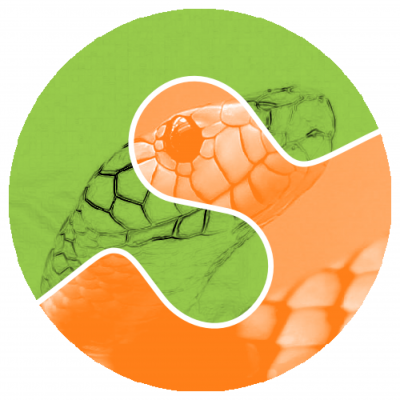

In [19]:
from IPython.display import Image
from IPython.core.display import HTML
from skimage import io # scikit-image for image processing
PATH="/home/gdib/Documents/PyCon-Italy"
IMAGE = PATH+ "/inputs/image_half.tif"
volume = io.imread(IMAGE) 
print('dataset is a {}'.format(type(volume)))
print('... of type {}'.format(volume.dtype))
print('... and with shape {}'.format(volume.shape))
Image(filename="/home/gdib/Documents/applications-group-meeting/img/scikit.png", retina=True)

dataset is a <class 'numpy.ndarray'>
... of type uint16
... and with shape (2304, 1280, 1024, 1)


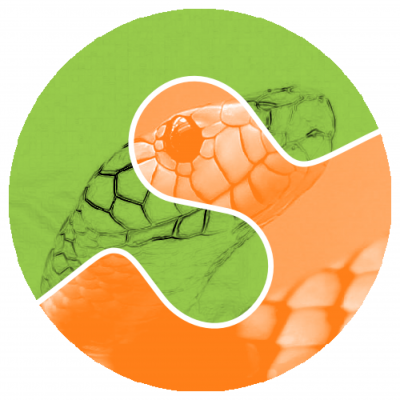

In [5]:
"""
Handle 16bit TIFF Images in Python. There seem to be quite a lot of problems with 16-bit grey scale TIFF images (especially with the Python Imaging Library - PIL).
"""
from IPython.display import Image
from IPython.core.display import HTML
from skimage import io # scikit-image for image processing
PATH="/home/gdib/Documents/PyCon-Italy"
IMAGE = PATH+ "/inputs/image_half.tif"
# The image is stored as a NumPy array. 
# Each entry in the array is a pixel value.
volume = io.imread(IMAGE) 
print('dataset is a {}'.format(type(volume)))
print('... of type {}'.format(volume.dtype))
print('... and with shape {}'.format(volume.shape))
Image(filename="/home/gdib/Documents/applications-group-meeting/img/scikit.png", retina=True)

### Exploring MRI Volume Slices in Python

<img src="./img/image_screen.png" width="80%" align="middle">

In [6]:
# Plot the MRI Slices
def plot_slices(slice):
    fig = plt.figure(figsize=(8.1,4.0))
    ax = fig.add_subplot(1,1,1)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    ax.minorticks_on()
    ax.tick_params('both', length=15, width=1.4, which='major')
    ax.tick_params('both', length=10, width=1.2, which='minor')
    cs = io.imshow(slice, cmap=cm.coolwarm)
    cbar = fig.colorbar(cs)
    plt.xlabel("Width (pixels)", fontsize=18)
    plt.ylabel("Height (pixels)", fontsize=18)
    plt.title(r'Brain slice at Z = 0 ',fontsize=18)
    plt.show()

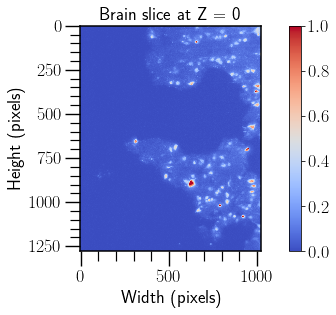

In [7]:
vol = volume.astype('float32') / (2**16 - 1) # Rescale the image
vol_ZYX = np.squeeze(vol) # Drop off the color (grayscale) channel
slice_ZY = vol_ZYX[:, :, 0] # "slicing" the hyper-rectangle
slice_YX = vol_ZYX[0, :, :]
slice_ZX = vol_ZYX[:, 0, :]
plot_slices(slice_YX) # Plot the MRI Slices

### Mixed-Scale Dense Convolutional Neural Network
*“In many scientific applications, tremendous manual labor is required to annotate and tag images — it can take weeks to produce a handful of carefully delineated images[...]. “Our goal was to develop a technique that learns from a very small data set.”*
<img src="./img/3-levels-of-neural-networks.png" width="50%" align="middle">

(Reference:  *D.M.Pelt & J.A.Sethian, 2017*, [**A mixed-scale dense convolutional neural networkfor image analysis**](https://www.pnas.org/content/pnas/early/2017/12/21/1715832114.full.pdf))

### Computational Challenges
- MS-DNet Training:
    * Implemented with TensorFlow on small patches of $96^{3}$
    * Model Size: 100K parameters (FCN for Semantic Segmentation)
- MS-DNet Inferencing:
    * Computational requirement: 16 Pflop
    * Memory requirement: 24 TB (with `TensorFlow`)
    * Standard DL frameworks do not (yet) provide *model-parallelism* at the inference step
    
<img src="./img/TF_logo.png" width="15%" align="right">

“fully  convolutional” networks  that  take  input  of  arbitrary  size  and  produce correspondingly-sized  output  with  efficient  inference  and learning.  
An FCN naturally operates on an input of any size, and produces an output of corresponding (possibly resampled) spatial dimensions.
inference step must be parallelized over multiple nodes

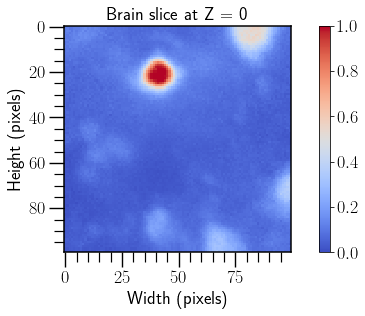

In [8]:
img_spot = vol[0:100, 1000:1100, 750:850]
img_spot_YX = img_spot[0, :, :]
img_spot_YX = np.squeeze(img_spot_YX)
plot_slices(img_spot_YX)

In [9]:
GROUND_TRUTH = PATH + "/inputs/locations_half.tif"
PARENT = PATH + "/tif_images/pred_notiled_max_0-100_1050-1150_800-900.tif"
CHILD = PATH + "/tif_images/pred_tiled_max_over_0_0-100_1050-1150_800-900.tif"
CHILD_OVER = PATH + "/tif_images/pred_tiled_max_over_25_0-100_1050-1150_800-900.tif"

## Inferencing: our Tile-based Strategy

In [10]:
# Load image as Numpy array
labels = io.imread(GROUND_TRUTH)
parent = io.imread(PARENT)
child = io.imread(CHILD)
child_over = io.imread(CHILD_OVER)

In [11]:
# Transform it in float
labels_float= labels.astype('float32')
parent_float= parent.astype('float32')
child_float= child.astype('float32')
child_over_float= child_over.astype('float32')

In [12]:
pixels_one = np.argwhere(labels_float == 1.0)
print("In the Ground Truths there are {} non-zero pixels".format(len(pixels_one)))
# Region selected to make inference 
region = labels_float[0:100, 1050:1150, 800:900]
centroids_px = np.argwhere(region == 1.0)
centroids_px # in pixels
(zo, yo, xo) = (0, 1050, 800) # lower-left corner

In the Ground Truths there are 13378 non-zero pixels


In [13]:
# in absolute coordinates
centroids = [centroids_px[i] + (zo, yo, xo) for i in range(len(centroids_px))]
centroids

[array([   0, 1081,  873]),
 array([   4, 1072,  849]),
 array([   6, 1102,  820]),
 array([  38, 1104,  808]),
 array([  44, 1070,  827]),
 array([  44, 1122,  810]),
 array([  48, 1108,  885]),
 array([  60, 1105,  807]),
 array([  80, 1149,  876])]

In [14]:
# Make a "sphere". We are considering spheroids of radius 5 each
z, y, x = np.ogrid[0:100,1050:1150,800:900]
mask0 = (z-centroids[0][0])**2 + (y-centroids[0][1])**2 + (x-centroids[0][2])**2 <= 5**2
mask1 = (z-centroids[1][0])**2 + (y-centroids[1][1])**2 + (x-centroids[1][2])**2 <= 5**2
mask2 = (z-centroids[2][0])**2 + (y-centroids[2][1])**2 + (x-centroids[2][2])**2 <= 5**2
mask3 = (z-centroids[3][0])**2 + (y-centroids[3][1])**2 + (x-centroids[3][2])**2 <= 5**2
mask4 = (z-centroids[4][0])**2 + (y-centroids[4][1])**2 + (x-centroids[4][2])**2 <= 5**2
mask5 = (z-centroids[5][0])**2 + (y-centroids[5][1])**2 + (x-centroids[5][2])**2 <= 5**2
mask6 = (z-centroids[6][0])**2 + (y-centroids[6][1])**2 + (x-centroids[6][2])**2 <= 5**2
mask7 = (z-centroids[7][0])**2 + (y-centroids[7][1])**2 + (x-centroids[7][2])**2 <= 5**2
mask8 = (z-centroids[8][0])**2 + (y-centroids[8][1])**2 + (x-centroids[8][2])**2 <= 5**2
# Mask the ground truth pixels
blobs = np.zeros((100,100,100))
blobs[mask0] = 1.0
blobs[mask1] = 1.0
blobs[mask2] = 1.0
blobs[mask3] = 1.0
blobs[mask4] = 1.0
blobs[mask5] = 1.0
blobs[mask6] = 1.0

<img src="./img/ground_truths.png" width="60%" align="middle">

<img src="./img/parent.png" width="60%" align="middle">

<img src="./img/child.png" width="60%" align="middle">

<img src="./img/child_overlap.png" width="60%" align="middle">

## Tile-based strategy goes parallel on MPCDF's clusters

<img src="./img/input_volume.png" width="30%" align="left">
<img src="./img/arrow.png" width="50%" align="middle">
<!--
<img src="./img/man.jpg" width="20%" align="left middle">
<img src="./img/job_slurm.png" width="30%" align="bottom">
-->
<img src="./img/Cobra-Rows.jpg" width="40%" align="right"> 

<!--**QUI METTERE SLURM JOB SCRIPT, SPIEGARE LA 'SUDDIVISIONE' GEOMETRICA, E ALCUNE FUNZIONALITA' DI SLURM JOB ARRAY**
-->

## 3D Tiling Solution Implemented on MPCDF's HPC Systems

<img src="./img/Workflow.png" width="65%" align="middle">

## Expanding Serial Analysis with SLURM Array
- Solution:
    - Submit a bunch of	similar serial jobs	each with their own job script
- Slurm **job arrays** can	help!
    - Create many jobs from	one	job	script!	Even 100’s of thousands!
  
<img src="./img/job_slurm.png" width="50%" align="right">

- If the job’s and their data are independent then we can
- Job arrays offer a mechanism for submitting and managing collections of similar jobs quickly and easily.

In [16]:
import dask.array as da
da.ones((2304,1280,1024), chunks=(768,256,512),dtype="float32")

dask.array<ones, shape=(2304, 1280, 1024), dtype=float32, chunksize=(768, 256, 512), chunktype=numpy.ndarray>

## How it works

<video width="800" height="400" src="./img/movie.m4v" controls>
<!--
<img src="./img/transition/transition.001.jpeg" width=80% align="middle">
-->

## Best practice


```bash
gdib@cobra01:~> cat test_job_array.sh
#!/bin/bash

#MAXarrayID=$SLURM_ARRAY_TASK_MAX 
# In a SLURM job-array script, will be set to the highest job array index
OVERLAP=50
ZMAX=768
YMAX=256
XMAX=512
ZMAXIMAGE=2304 # e.g 2048 number of stack of 2D images
YMAXIMAGE=1280 # e.g 1024 height of the image
XMAXIMAGE=1024 # e.g 1024 depth of the image

# The idea is to do 3D -> 1D mapping. For example, for a 3D matrix with dimensions "width",
# "height" and "depth", e.g.:
# id = x + (width*y) + (width*height*z);
# and reverse:
# x = id % width;
# y = (id / width)%height
# z = id / (width*height);
# Think about ZMAXIMAGE/ZMAX (and the same in the other directions) as the number of tiles in a row

MAXarrayID=$(( $ZMAXIMAGE / $ZMAX * $YMAXIMAGE / $YMAX * $XMAXIMAGE / $XMAX ))
# in a SLURM job array the for-loop is given "for free"
# arrayID is a SLURM ENV variable

for (( arrayID=0; arrayID < $MAXarrayID; arrayID++ ))
do

    x=$(( $arrayID % ($XMAXIMAGE / $XMAX) ))
    y=$((($arrayID / ($XMAXIMAGE / $XMAX)) % ($YMAXIMAGE / $YMAX) ))
    z=$(( $arrayID / ( ($XMAXIMAGE / $XMAX)*($YMAXIMAGE / $YMAX) ) ))
    
    ZSTART=$(( $z * $ZMAX - $OVERLAP ))
    ZEND=$(( ($z + 1) * $ZMAX + $OVERLAP ))
    YSTART=$(( $y * $YMAX -$OVERLAP ))
    YEND=$(( ($y + 1) * $YMAX + $OVERLAP ))
    XSTART=$(( $x * $XMAX -$OVERLAP ))
    XEND=$(( ($x + 1) * $XMAX + $OVERLAP ))

    if [[ $ZSTART -lt 0 ]]; then
        ZSTART=0
    fi
    if [[ $ZEND -gt $ZMAXIMAGE ]]; then
        ZEND=$ZMAXIMAGE
    fi
    if [[ $YSTART -lt 0 ]]; then
        YSTART=0
    fi
    if [[ $YEND -gt $YMAXIMAGE ]]; then
        YEND=$YMAXIMAGE
    fi
    if [[ $XSTART -lt 0 ]]; then
        XSTART=0
    fi
    if [[ $XEND -gt $XMAXIMAGE ]]; then
        XEND=$XMAXIMAGE
    fi

    tmpID=$(( $x + ($XMAXIMAGE / $XMAX)*$y + ($XMAXIMAGE / $XMAX) * ($YMAXIMAGE / $YMAX) *$z ))
    echo "Id: $arrayID; MaxID: $MAXarrayID; ComputedID: $tmpID; zyx: $z $y $x; Z: $ZSTART $ZEND; Y: $YSTART $YEND; X: $XSTART $XEND"

done
```

```bash 
$ ./test_job_array.sh
Id: 0; MaxID: 30; ComputedID: 0; zyx: 0 0 0; Z: 0 818; Y: 0 306; X: 0 562
Id: 1; MaxID: 30; ComputedID: 1; zyx: 0 0 1; Z: 0 818; Y: 0 306; X: 462 1024
Id: 2; MaxID: 30; ComputedID: 2; zyx: 0 1 0; Z: 0 818; Y: 206 562; X: 0 562
Id: 3; MaxID: 30; ComputedID: 3; zyx: 0 1 1; Z: 0 818; Y: 206 562; X: 462 1024
Id: 4; MaxID: 30; ComputedID: 4; zyx: 0 2 0; Z: 0 818; Y: 462 818; X: 0 562
Id: 5; MaxID: 30; ComputedID: 5; zyx: 0 2 1; Z: 0 818; Y: 462 818; X: 462 1024
Id: 6; MaxID: 30; ComputedID: 6; zyx: 0 3 0; Z: 0 818; Y: 718 1074; X: 0 562
Id: 7; MaxID: 30; ComputedID: 7; zyx: 0 3 1; Z: 0 818; Y: 718 1074; X: 462 1024
Id: 8; MaxID: 30; ComputedID: 8; zyx: 0 4 0; Z: 0 818; Y: 974 1280; X: 0 562
Id: 9; MaxID: 30; ComputedID: 9; zyx: 0 4 1; Z: 0 818; Y: 974 1280; X: 462 1024
Id: 10; MaxID: 30; ComputedID: 10; zyx: 1 0 0; Z: 718 1586; Y: 0 306; X: 0 562
Id: 11; MaxID: 30; ComputedID: 11; zyx: 1 0 1; Z: 718 1586; Y: 0 306; X: 462 1024
Id: 12; MaxID: 30; ComputedID: 12; zyx: 1 1 0; Z: 718 1586; Y: 206 562; X: 0 562
Id: 13; MaxID: 30; ComputedID: 13; zyx: 1 1 1; Z: 718 1586; Y: 206 562; X: 462 1024
Id: 14; MaxID: 30; ComputedID: 14; zyx: 1 2 0; Z: 718 1586; Y: 462 818; X: 0 562
Id: 15; MaxID: 30; ComputedID: 15; zyx: 1 2 1; Z: 718 1586; Y: 462 818; X: 462 1024
Id: 16; MaxID: 30; ComputedID: 16; zyx: 1 3 0; Z: 718 1586; Y: 718 1074; X: 0 562
Id: 17; MaxID: 30; ComputedID: 17; zyx: 1 3 1; Z: 718 1586; Y: 718 1074; X: 462 1024
Id: 18; MaxID: 30; ComputedID: 18; zyx: 1 4 0; Z: 718 1586; Y: 974 1280; X: 0 562
Id: 19; MaxID: 30; ComputedID: 19; zyx: 1 4 1; Z: 718 1586; Y: 974 1280; X: 462 1024
Id: 20; MaxID: 30; ComputedID: 20; zyx: 2 0 0; Z: 1486 2304; Y: 0 306; X: 0 562
Id: 21; MaxID: 30; ComputedID: 21; zyx: 2 0 1; Z: 1486 2304; Y: 0 306; X: 462 1024
Id: 22; MaxID: 30; ComputedID: 22; zyx: 2 1 0; Z: 1486 2304; Y: 206 562; X: 0 562
Id: 23; MaxID: 30; ComputedID: 23; zyx: 2 1 1; Z: 1486 2304; Y: 206 562; X: 462 1024
Id: 24; MaxID: 30; ComputedID: 24; zyx: 2 2 0; Z: 1486 2304; Y: 462 818; X: 0 562
Id: 25; MaxID: 30; ComputedID: 25; zyx: 2 2 1; Z: 1486 2304; Y: 462 818; X: 462 1024
Id: 26; MaxID: 30; ComputedID: 26; zyx: 2 3 0; Z: 1486 2304; Y: 718 1074; X: 0 562
Id: 27; MaxID: 30; ComputedID: 27; zyx: 2 3 1; Z: 1486 2304; Y: 718 1074; X: 462 1024
Id: 28; MaxID: 30; ComputedID: 28; zyx: 2 4 0; Z: 1486 2304; Y: 974 1280; X: 0 562
Id: 29; MaxID: 30; ComputedID: 29; zyx: 2 4 1; Z: 1486 2304; Y: 974 1280; X: 462 1024
```

## Recipe for running Inference on MPCDF HPC's system


```bash
#!/bin/bash -l
# Standard output and error:
#SBATCH -o ./array_Job.%A.%a.out
#SBATCH -e ./array_Job.%A.%a.err
# Initial working directory:
#SBATCH -D ./
# Job Name:
#SBATCH -J job_array      # Job name
# Queue:
#
#SBATCH --partition=medium
# Number of nodes and MPI tasks per node:
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
# Enable Hyperthreading:
#SBATCH --ntasks-per-core=2
# for OpenMP:
#SBATCH --cpus-per-task=20

#SBATCH --mail-type=all
#SBATCH --mail-user=gdib@mpcdf.mpg.de
# Job array
#SBATCH --array=0-29
# wall clock limit
#SBATCH --time=08:00:00
# Load modules
module load gcc/8
module load impi/2018.2 # Intel MPI Library
module load anaconda/3/5.1
module load tensorflow/cpu/1.12.0
pwd; hostname; date

arrayID=$SLURM_ARRAY_TASK_ID     # will be set to the job array index value (note, it's a string)
MAXarrayID=$SLURM_ARRAY_TASK_MAX # will be set to the highest job array index
# MAXarrayID=$(( $ZMAXIMAGE / $ZMAX * $YMAXIMAGE / $YMAX * $XMAXIMAGE / $XMAX )) this is the number - in theory to be computed previously

OVERLAP=50
ZMAX=768
YMAX=256
XMAX=512
ZMAXIMAGE=2304 # e.g 2048 number of stack of 2D images
YMAXIMAGE=1280 # e.g 1024 height of the image
XMAXIMAGE=1024 # e.g 1024 depth of the image

x=$(( $arrayID % ($XMAXIMAGE / $XMAX) ))
y=$((($arrayID / ($XMAXIMAGE / $XMAX)) % ($YMAXIMAGE / $YMAX) ))
z=$(( $arrayID / ( ($XMAXIMAGE / $XMAX)*($YMAXIMAGE / $YMAX) ) ))

ZSTART=$(( $z * $ZMAX - $OVERLAP ))
ZEND=$(( ($z + 1) * $ZMAX + $OVERLAP ))
YSTART=$(( $y * $YMAX -$OVERLAP ))
YEND=$(( ($y + 1) * $YMAX + $OVERLAP ))
XSTART=$(( $x * $XMAX -$OVERLAP ))
XEND=$(( ($x + 1) * $XMAX + $OVERLAP ))

if [[ $ZSTART -lt 0 ]]; then
     ZSTART=0
fi
if [[ $ZEND -gt $ZMAXIMAGE ]]; then
     ZEND=$ZMAXIMAGE
fi
if [[ $YSTART -lt 0 ]]; then
     YSTART=0
fi
if [[ $YEND -gt $YMAXIMAGE ]]; then
     YEND=$YMAXIMAGE
fi
if [[ $XSTART -lt 0 ]]; then
     XSTART=0
fi
if [[ $XEND -gt $XMAXIMAGE ]]; then
    XEND=$XMAXIMAGE
fi

# Print coordinates
echo "This is the task $arrayID, which will do runs $ZSTART to $ZEND in Z"
echo "... $YSTART to $YEND in Y"
echo "... and $XSTART to $XEND in X"
echo "While the highest job array index is $MAXarrayID"
tmpID=$(( $x + ($XMAXIMAGE / $XMAX)*$y + ($XMAXIMAGE / $XMAX) * ($YMAXIMAGE / $YMAX) *$z ))
echo "Id: $arrayID; MaxID: $MAXarrayID; ComputedID: $tmpID; zyx: $z $y $x; Z: $ZSTART $ZEND; Y: $    YSTART $YEND; X: $XSTART $XEND"
srun python leipzig_parallel.py --id $arrayID --tiles --stiching="max" --overlap $OVERLAP --window 100 --z_a $ZSTART --z_b $ZEND --y_a $YSTART --y_b $YEND --x_a $XSTART --x_b $XEND
echo "job finished"
```
<img src="./img/slurm_fun.png" width="50%" align="right">

### Modify the Initial Code ...

```python
def predictImageWithTiles(model, image,
        tile_size=(50,50,50),
        overlap=25, # 50% of overlap
        offset = 0,
        stiching = "max"):
    """This is a help function to calculate predictions on the initial image pixel-by-pixel.
    At each step, predictions are computed in corrispondence of the volume occupied by the tile (dim, dim, dim).
    Then the overlap region between two neighbouring tiles is updated with the maximum prediction value.
    """
    depth_limit = image.shape[0]
    height_limit = image.shape[1]
    width_limit = image.shape[2]
    zdim, ydim, xdim = tile_size # dimensions of each tile or sub-cube
    prediction = np.zeros((depth_limit, height_limit, width_limit, 1), dtype='float32') # output tensor with the same shape as the input image
    print("The image to be predicted has shape: {}".format(prediction.shape))
    # create input, label patches 
    rects = [] # input data region
    o_patches = []
    for z in range(0, depth_limit, zdim - overlap): # step = zdim - overlap
        for y in range(0, height_limit, ydim - overlap): # step = ydim - overlap
            for x in range(0, width_limit, xdim - overlap): # step = xdim - overlap
                if (z + zdim > depth_limit) or (y + ydim > height_limit) or (x + xdim > width_limit):
                    break
                rects.append((z - offset, y - offset, x - offset,
                    z - offset + zdim, y - offset +  ydim, x - offset + xdim))
                o_patch = image[z:z+zdim, y:y+ydim, x:x+xdim]
                o_patches.append(o_patch)
                prediction_tile = model.predict(np.expand_dims(o_patch, axis=0), verbose =1,batch_size=1)[0] # considering the "0th" batch element
                if stiching == "max":
                    prediction[z:z+zdim, y:y+ydim, x:x+xdim] = np.maximum(prediction[z:z+zdim, y:y+ydim, x:x+xdim], prediction_tile)

    n_patches = len(o_patches)
    print("The selected image has  been divided into {} overlapping tiles".format(n_patches))
    return prediction
```

```python
if __name__ ==  '__main__':
    parser = argparse.ArgumentParser(description='This is an embarassingly parallel job')
    parser.add_argument('-t', '--tiles', action='store_true', dest='TILES',
            help='Do you want to tile your image or not?')
    parser.add_argument('-s', '--sticthing', action='store_true', dest='STICHING',
            help='What kind of stiching method do you want?')
    parser.add_argument('-o', '--overlap', dest='OVERLAP', type=float, default=25,
            help='Tile overlap')
    parser.add_argument('-w','--window_size', dest='TILE', type=float,default=50,
            help='Tile size')
    parser.add_argument('-z_a', dest='Z_A', type=float, default=0,
            help='start in Z')
    parser.add_argument('-z_b', dest='Z_B', type=float, default=100,
            help='end in z')
    parser.add_argument('-y_a', dest='Y_A', type=float, default=1050,
            help='start in y')
    parser.add_argument('-y_b', dest='Y_B', type=float, default=1150,
            help='end in y')
    parser.add_argument('-x_a', dest='X_A', type=float, default=800,
            help='start in x')
    parser.add_argument('-x_b', dest='X_B', type=float, default=900,
            help='end in x')
    args = parser.parse_args()

    print(args)
    image = IMAGE[args.z_a:args.z_b, args.y_a:args.y_b, args.x_a:args.x_b]

    if args.tiles:
        print("We are making inference with overlap-tiling strategy")
        predictions = predictImageWithTiles(model,
            image = image,
            tile_size = (TILE, TILE, TILE),
            overlap = OVERLAP,
            stiching = STICHING)
    else:
        print("We are making inference without overlap-tiling strategy")
        predictions = predictImageAsItIs(model,
            image = image)
```

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import re
import glob
import argparse
import warnings
import numpy as np
import matplotlib.cm as cm
warnings.filterwarnings('ignore')
from matplotlib import rc, rcParams
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

## 3D Reconstruction


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2 as cv
from skimage import io
ZMAX=768 # is the dimension of each tile along z 
YMAX=256 # is the dimension of each tile along y
XMAX=512 # is the dimension of each tile along x
OVERLAP=50
ZMAXIMAGE=2304 # dimension of the original image along z 
YMAXIMAGE=1280 # dimension of the original image along y
XMAXIMAGE=1024 # dimension of the original image along x

# Let's properly order the results of job arrays
dir = "./inference/" #working  directory
ext = ".tif" # whatever extension you want
pathname = os.path.join(dir, "*" + ext)
# First get files
files =glob.glob(pathname)
# files = [file for file in sorted(glob.glob(pathname))] # sorted by filename
# if you want sort files according to the digits included in the filename, you can do as following:
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
files

# Let's "glue" the tiles all togheter
```python
def threeDreconstruct(files):

    result = np.zeros((ZMAXIMAGE, YMAXIMAGE, XMAXIMAGE), dtype='float32') # the output volume
    for index, file in enumerate(files):
        image = io.imread(file)
        image = np.squeeze(image) # the TF output is a tensor (d,h,w,c)
        image = image.astype('float32')/(255) 

        x = index % (XMAXIMAGE // XMAX)
        y = index // (XMAXIMAGE // XMAX) % (YMAXIMAGE // YMAX)
        z = index // ((XMAXIMAGE // XMAX) * (YMAXIMAGE // YMAX))

        ZSTART = z * ZMAX - OVERLAP
        ZEND = (z + 1) * ZMAX + OVERLAP
        YSTART = y * YMAX - OVERLAP
        YEND = (y + 1) * YMAX + OVERLAP
        XSTART = x * XMAX - OVERLAP
        XEND = (x + 1) * XMAX + OVERLAP
        if ZSTART < 0:
            ZSTART = 0
        if ZEND > ZMAXIMAGE:
            ZEND = ZMAXIMAGE
        if YSTART < 0:
            YSTART = 0
        if YEND > YMAXIMAGE:
            YEND = YMAXIMAGE
        if XSTART < 0:
            XSTART = 0
        if XEND > XMAXIMAGE:
            XEND = XMAXIMAGE

        print("Processing Image: {}".format(file))
        print("index {}".format(index), "z y x {}{}{}".format(z, y, x))
        print("ZSTART {} ZEND {} YSTART {} YEND {} XSTART {} XEND {}".format(ZSTART, ZEND, YSTART, YEND, XSTART, XEND))    
        result[ZSTART:ZEND, YSTART:YEND, XSTART:XEND] = np.maximum(result[ZSTART:ZEND, YSTART:YEND, XSTART:XEND],image)
    result = (result*255).astype('uint8')
    print("final array with shape {}".format(result.shape))
    print("final array is a {}".format(type(result)))
    print("with data type {}".format(result.dtype))
    return io.imsave("tiling_skylake.tif", result)

if __name__ == '__main__':
    threeDreconstruct(files)
```

## Results
***30 SLURM Job Arrays, on 15 Computing Nodes***

- 2 NVIDIA-V100-Tensor-Core GPUs, 32 GB  (a job x each GPU): ~ 480 sec.
- 80 CPUs (hyperthreading enabled) Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz: ~ 5000 sec.

<!--<img src="./img/NVIDIA-V100-Tensor-Core-Math.jpg" width="50%" align="left">-->
<img src="./img/volta100.png" width="35%" align="left">
<img src="./img/intelXeon.jpg" width="25%" align="right">

NVIDIA® Tesla® V100 Tensor Core is the most advanced data center GPU ever built to accelerate AI, high performance computing (HPC), data science and graphics. It’s powered by NVIDIA Volta architecture, comes in 16 and 32GB configurations, and offers the performance of up to 100 CPUs in a single GPU. Data scientists, researchers, and engineers can now spend less time optimizing memory usage and more time designing the next AI breakthrough.

## OpenVINO 3D MRI Brain Tissue Segmentation

OpenVINO™ Out Of the Box + Custom Solution:

- OOB Activation memory reuse during execution
<!--- Custom 3D convolution primitive for dilation and 1 output-->
- Custom automatic topology transformation during import to reduce data dependency

RESULTS:
- Inference can be executed on a **single XEON node**
- OpenVINO™ memory reuse reduces **memory requirement to 1.2 TB**
- Inference time for whole model using OpenVINO™: **41 minutes**

(Aknowledgments: D. Gorokhov, Yury Gorbachev, V. Kostarev from Intel for sharing material)
<img src="./img/intelAI.jpg" width="10%" align="left">

## Evaluation
<!--
<img src="./img/image_190.png" width="50%" align="top">
<img src="./img/inference_190.png" width="50%" align="bottom">
<img src="./img/locations_conv3D.png" width="50%" align="right">
<img src="./img/openvino_190.png" width="50%" align="left">
-->
<img src="./img/evaluation.png" width="90%" align="top">


## Ongoing & Future Work

- Tuning parameters (e.g. tile size; overlap)
- Improving the stiching strategy
- Growing the Training Set and Improving Predictions Quality
    - accuracy of the AI predicted centroid segments can be further improved 
- Deep Image Prior
    - Speed up and Parallelizzation strategy

# Denosing of 3D Brain MRI Images with CNN
**In collaboration with MPI for Human Cognitive and Brain Sciences (HBCS)**  
***(Podranski, K., Scharf, N., Weiskopf, N.)***<img src="./img/mpi-brain-cognitive.png" width="30%" align="right">

- Goal: Denoising and generic reconstruction: filter out noise from an image
- Method: given a noisy image $x_{0}$, we want to recover a clean image $x^{*} = f_{\theta^{*}}(z)$, after substituting the minimizer $\theta^{*}$ obtained using an optimizer such as gradient descent starting from a *random initialization of the parameters*

### Neuroimaging in Python 

- **NiBabel**: Read +/- write access to some common medical and neuroimaging file formats
- Each data set includes magnetic resonance imaging data in *Neuroimaging Informatics Technology Initiative* (NIFTI, `.nii.gz`) file format. E.g. a 256$\times$256$\times$150 MRI image from <a href="http://brain-development.org/ixi-dataset">:http://brain-development.org/ixi-dataset</a>

<img src="./img/vol_nilearn.png" width="45%" align="left"><img src="./img/nipy-logo.png" width="10%" align="right">

NiBabel is a python package, under the NiPy project, that aims at unifying the process of opening different medical and neuroimaging file formats, including: ANALYZE (plain, SPM99, SPM2), GIFTI, NIfTI1, MINC, MGH and ECAT as well as PAR/REC. The package is also able to read and write Freesurfer format.

## Deep Image Prior

<img src="./img/deep-image-prior.gif" width="80%" align="center">

(Web page: <a href="https://dmitryulyanov.github.io/deep_image_prior">https://dmitryulyanov.github.io/deep_image_prior</a>)

### Deep Image Prior Architecture

- Fully-convolutional architectures  
    - Input: a random code tensor/vector $z \in \mathbb{R}^{C' \times W \times H}$
    - Output: image $x = f_{\theta}(z) \in \mathbb{R}^{3 \times W \times H}$

<img src="./img/deep-image-prior-arch.png" width="80%" align="center">

Seminal paper: **Deep Image Prior**, *Dmitry Ulianov, Andrea Vedaldi & Victor Lemptisky, 2017*: <a href="https://sites.skoltech.ru/app/data/uploads/sites/25/2018/04/deep_image_prior.pdf">https://sites.skoltech.ru/app/data/uploads/sites/25/2018/04/deep_image_prior.pdf</a>

### References

Seminal paper: **Deep Image Prior**, *Dmitry Ulianov, Andrea Vedaldi & Victor Lemptisky, 2017*: <a href="https://sites.skoltech.ru/app/data/uploads/sites/25/2018/04/deep_image_prior.pdf">https://sites.skoltech.ru/app/data/uploads/sites/25/2018/04/deep_image_prior.pdf</a>  

Web page: <a href="https://dmitryulyanov.github.io/deep_image_prior">https://dmitryulyanov.github.io/deep_image_prior</a>  

Code: <a href="https://github.com/DmitryUlyanov/deep-image-prior">https://github.com/DmitryUlyanov/deep-image-prior</a>

(Supplement material: <a href="https://box.skoltech.ru/index.php/s/ib52BOoV58ztuPM#pdfviewer">https://box.skoltech.ru/index.php/s/ib52BOoV58ztuPM#pdfviewer</a>)

## Deep Image Prior: 3D Implementation of the Original Paper



```python
############################## NEURAL NETWORK ##############################
def skip3d(num_input_channels=2, num_output_channels=3,
           num_channels_down=[16, 32, 64, 128, 128],
           num_channels_up=[16, 32, 64, 128, 128],
           num_channels_skip=[4, 4, 4, 4, 4],
           filter_size_down=3,
           filter_size_up=3,filter_skip_size=1,
           upsample_mode="nearest", downsample_mode="stride",
           act_fun="LeakyReLU",
           need_sigmoid=True,
           need_bias=True, pad='zero',
           need1x1_up=True):
    """Assembles encoder-decoder CNN with skip connections.
    
    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    
    Returns:
        model according to given arguments
    """
```

## Deep Image Prior: 3D Implementation of the Original Paper

<span style="display:block; height: 20;"></span>
```python
############################## NEURAL NETWORK ##############################
def skip3d(arguments):
    """Assembles encoder-decoder CNN with skip connections.
    
    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    
    Returns:
        model according to given arguments
    """
```

### Hyparparameter choosen

<span style="display:block; height: 20;"></span>

```python
def main():
    ## global inits
    input_depth = 32      # number of noise channels (feature maps) to use as AE input
    layer_depth = [128]*4 # number of channels to use at each scale
    skip_depth = [4]*4    # number of channels to use for skip connections
    layer_kernel = 3      # size of the convolution kernels in layers
    skip_kernel = 1       # size of the convolution kernels in skip layers
    noise_stddev=1./30.   # sigma for input pertubation
    epochs = 5000         # number of epochs to train
    lr = 0.01             # learning rate to use
```

Number of network parametes: $\geq 6M$

## Computational Challenges

<span style="display:block; height: 20;"></span>
<section>
<dl>
<li class="fragment fade-right">Deep Image Prior Training - Denoising of 3D Medical Images
    <ul>
       <span style="display:block; height: 5;"></span>
       <li class="fragment" style="color:red;">Number of network parameters: $\bf \geq 6M$ </li>
       <li class="fragment"><code>RuntimeError: CUDA out of memory. Tried to allocate [...]</code></li> 
    </ul>
  </li>
</dl>    
<p class="fragment fade-right"><img src="./img/Gpus_Memory_Consumption.png" width="45%" align="center"><p>
</section>

## Solution Implemented on MPCDF's HPC Systems

<span style="display:block; height: 10;"></span>

<section>
<ol>
<li class="fragment fade-right">Using <font color="green">Tensor Cores</font> for <font color="green">Mixed-Precision</font> Scientific Computing
    <ul>
       <span style="display:block; height: 5;"></span>
       <li class="fragment"><font color="green">NVIDIA/Apex</font>
            <ul>
                <li class="fragment">more <font color="green">memory-efficient</font></li>
                <li class="fragment">improve <font color="green">training speed</font></li>
                <li class="fragment">with <font color="green">no achitecture change</font></li>
            </ul>
       </li>
     </ul>
</li>
<li class="fragment fade-right">The model is (<b>still!</b>) too large to fit into a single GPU: distributed training technique
    <ul>
        <span style="display:block; height: 5;"></span>
        <li class="fragment"><font color="red">Model Parallelism</font>: split a single model on (two) separate (V100) GPUs
        </li>
    </ul>
</li>
</ol>
</section>

Inspired by state-of-the-art mixed precision training in translational networks, sentiment analysis, and image classification, NVIDIA PyTorch developers have created tools bringing these methods to all levels of PyTorch users. Mixed precision utilities in Apex are designed to improve training speed while maintaining the accuracy and stability of training in single precision. Specifically, Apex offers automatic execution of operations in either FP16 or FP32, automatic handling of master parameter conversion, and automatic loss scaling, all available with 4 or fewer line changes to the existing code. Mixed precision utilities in Apex are designed to improve training speed while maintaining the accuracy and stability of training in single precision.

### What is Mixed Precision?

- <span style="color:green">PyTorch has a comprehensive support for FP16</span>
    - Convert a tensor to FP16: `my_tensor.half()`
    - Convert a module to FP16: `my_module.half()`
    
- <span style="color:green">Mixed precision</span>
     - Most of the network in <span style="color:green">FP16</span>
     - A few carefully selected `ops` in the <span style="color:green">FP32</span>
     <img src="./img/fp32vsfp16.png" width="80%" align="bottom">
<!--<img src="./img/what-is-mp.png" width="30%" align="right">-->


Mixed precision training offers significant computational speedup by performing operations in half-precision format, while storing minimal information in single-precision to retain as much information as possible in critical parts of the network. 
Mixed Precision is the combined use of different numerical precisions in a computational method.

### Why Mixed Precision?
<span style="display:block; height: 10;"></span>
<font color="green">1. Weight updates benefit from the precision of FP32</font>  
`1 + 0.0001 = ???`

```python
>>> param = torch.cuda.HalfTensor([1.0])
>>> update = torch.cuda.HalfTensor([0.0001])  
>>> print(param + update)
>>> 1
```
<font color="red">In FP16, when update/param < 2e-11 ~ 0.00049, update has no effect.</font>

```python
>>> param = torch.cuda.FloatTensor([1.0])
>>> update = torch.cuda.FloatTensor([0.0001])  
>>> print(param + update)
>>> 1.0001 
```


### Why Mixed Precision?
<span style="display:block; height: 10;"></span>
<font color="green">2. Certain ops benefit from the precision of FP32</font>  
`BatchNorm, reductions, exponentiations`

```bash
>>> a = torch.cuda.HalfTensor(4096)
>>> a.fill_(16)
tensor([16., 16., 16.,  ..., 16., 16., 16.], device='cuda:0',
       dtype=torch.float16)
>>> a.sum()
tensor(inf, device='cuda:0', dtype=torch.float16)
>>>
```

```bash
>>> b = torch.cuda.FloatTensor(4096)
>>> b.fill_(16)  
>>> b.sum()
tensor(65536., device='cuda:0')
>>>  
```

### Maximizing Model Performance
<span style="display:block; height: 10;"></span>
<font color="green">2.1 Assign each operation its optimal precision</font>
- <font color="green">FP16</font>
    - GEMMs + Conv. can use Tensor Cores
    - 2X memory throughput


- <font color="blue">FP32</font>
    - Weight updates benefit from `fp32` precision
    - Loss functions benefit from precision and range
    - `Softmax`, norms, some other ops benefit from precision and range

### Why Mixed Precision?
<span style="display:block; height: 10;"></span>
<font color="green">3. Small gradients may underflow in FP16 regions of the network</font>

<section>
<dl>
<li><font color="green">Loss scaling</font>
    <ul>
        <li> Multiply the loss by some constant S.
            <ul>
             <li><code>scaled_loss = loss*S</code></li>
    </ul>
         <li> Call <code>backward()</code> on <code>scaled loss</code>.
             <ul>
              <li><code>scaled_loss.backward()</code>   
              By the chain rule, gradients will also be scaled by S.
              This preserves small gradient values.</li>
                 </ul>
         <li> Unscale gradients before <code>optimizer.step().</code></li>
        </ul>
    </li>
</dl>
</section>

### Why Mixed Precision?
<span style="display:block; height: 10;"></span>
<font color="green">3. Small gradients may underflow in FP16 regions of the network</font>

<img src="./img/gradient_underflow.png" width="100%" align="center">

### Why Mixed Precision?
<span style="display:block; height: 10;"></span>
<font color="green">3. Small gradients may underflow in FP16 regions of the network</font>

<img src="./img/loss_scaling.png" width="100%" align="center">

### Why Mixed Precision?
<span style="display:block; height: 10;"></span>
<font color="green">3. Small gradients may underflow in FP16 regions of the network</font>

<img src="./img/unscale_loss.png" width="100%" align="center">

## The (Distributed) Mixed Precision Recipe for Deep Image Prior
<span style="display:block; height: 10;"></span>

- Master weights in FP32
- Leave some ops in FP32
- Loss (gradient) scaling

```python
import apex
# 1."Model" parallelism
down, up = get_net(args)
down = down.cuda(0).half()
up = up.cuda(1).half()

# 2. Mixed precision Training with FP16_Optimizer Apex class
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 2.1 Construct FP16_Optimizer
optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)

# 2.2 loss.backward() becomes:
loss = torch.nn.MSELoss(output, target)
optimizer.backward(loss) # backpropagation, formerly loss.backward()
optimizer.step()
```

## Results

<img src="./img/noisevsdenoise.png" width="50%" align="right">
<img src="./img/psnr.png" width="50%" align="left">

## Thank you!

Questions: giuseppe.di-bernardo@mpcdf.mpg.de